In [43]:
import pandas as pd
import random as rd
import seaborn as sns
import matplotlib.pyplot as plt

# Dados

## explorando dados

In [41]:
df_data = pd.read_csv('final_data_clean.csv')

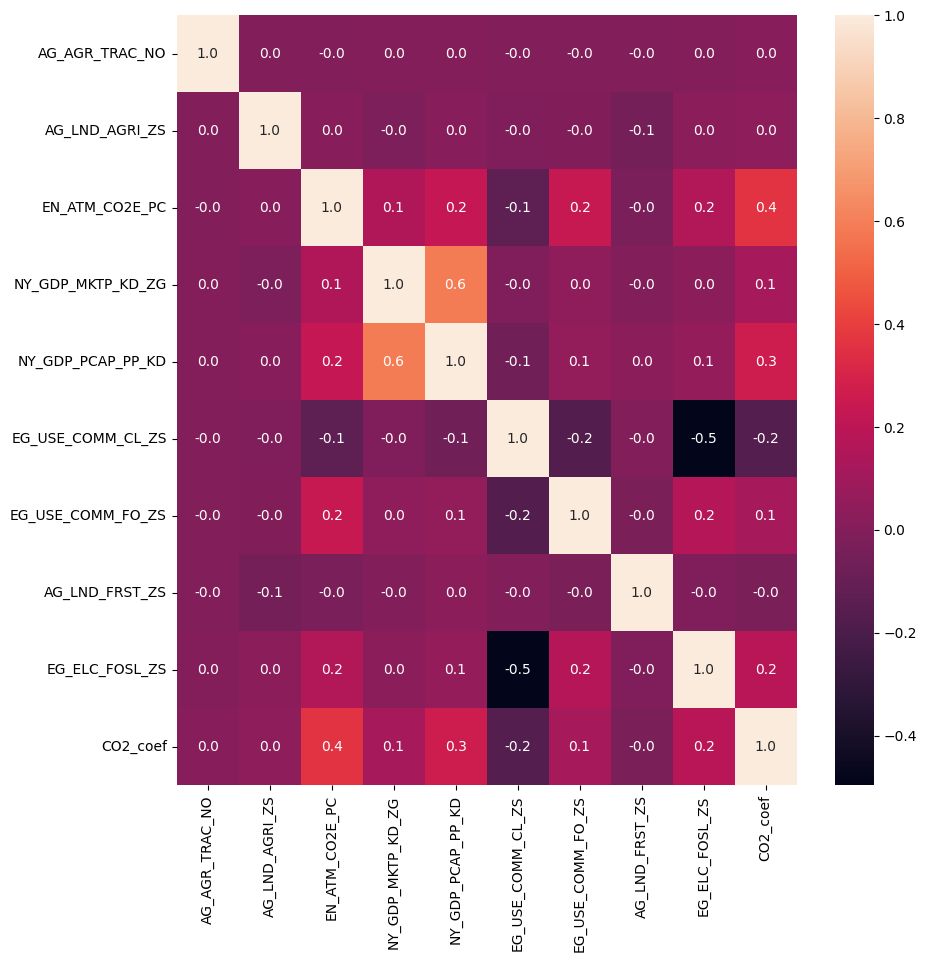

In [48]:
plt.figure(figsize=(10,10))
data_corr = df_data.drop(columns=['economy', 'ano'])
sns.heatmap(data_corr.corr(), annot=True, fmt='.1f')
plt.show()

## Divisão dos dados
Adotaremos a regra de ouro 70, 15, 15:
- 70% de dados para treino
- 15% de dados para teste
- 15% de dados para validação

In [37]:
class Data():
    def __init__(self, X_data, y_data_co2, y_data_coef, 
                 train_size = 0.7, test_size = 0.15,  
                 random_seed = 42):
        self.X_data = X_data
        self.y_data_co2 = y_data_co2
        self.y_data_coef = y_data_coef
        self.train_size = train_size
        self.test_size = test_size
        self.random_seed = random_seed
        self.size = len(self.X_data)

    def split_data(self):
        ###### SEPARANDO DADOS DE TREINO ######
        indexes_train = rd.sample(range(0, len(self.X_data)), int(self.size*self.train_size)) #separando index de treino
        self.X_train = self.X_data.iloc[indexes_train] #separando dados de treino X
        self.y_train_coef = self.y_data_coef.iloc[indexes_train] #separando dados de treino Y
        self.y_train_co2 = self.y_data_co2.iloc[indexes_train] #separando dados de treino Y

        ###### REMOVENDO DADOS DE TREINO ###### 
        self.X_data = self.X_data.drop(indexes_train) #removendo dados de treino X
        self.X_data = self.X_data.reset_index(drop=True) #resetando index

        self.y_data_coef = self.y_data_coef.drop(indexes_train) #removendo dados de treino Y
        self.y_data_coef = self.y_data_coef.reset_index(drop=True) #resetando index

        self.y_data_co2 = self.y_data_co2.drop(indexes_train) #removendo dados de treino Y
        self.y_data_co2 = self.y_data_co2.reset_index(drop=True) #resetando index

        ###### SEPARANDO DADOS DE TESTE ######
        indexes_test = rd.sample(range(0, len(self.X_data)), int(self.size*self.test_size)) #separando index de teste
        self.X_test = self.X_data.iloc[indexes_test] #separando dados de teste X
        self.y_test_coef = self.y_data_coef.iloc[indexes_test] #separando dados de teste Y
        self.y_test_co2 = self.y_data_co2.iloc[indexes_test] #separando dados de teste Y

        ###### REMOVENDO DADOS DE TESTE ######
        self.X_data = self.X_data.drop(indexes_test) #removendo dados de teste X
        self.X_data = self.X_data.reset_index(drop=True) #resetando index

        self.y_data_coef = self.y_data_coef.drop(indexes_test) #removendo dados de teste Y
        self.y_data_coef = self.y_data_coef.reset_index(drop=True) #resetando index

        self.y_data_co2 = self.y_data_co2.drop(indexes_test) #removendo dados de teste Y
        self.y_data_co2 = self.y_data_co2.reset_index(drop=True) #resetando index

        ##### SEPARANDO DADOS DE VALIDAÇÃO ######
        self.X_validation = self.X_data #separando dados de validação X
        self.y_validation_coef = self.y_data_coef #separando dados de validação Y
        self.y_validation_co2 = self.y_data_co2 #separando dados de validação Y
    
    def get_data_train(self):
        return self.X_train, self.y_train_co2, self.y_train_coef

    def get_data_test(self):
        return self.X_test, self.y_test_co2, self.y_test_coef
    
    def get_data_validation(self):
        return self.X_validation, self.y_validation_co2, self.y_validation_coef
    


In [38]:
y_data_co2 = df_data['EN_ATM_CO2E_PC'] #para verificar quanto vai subir (rede neural)
y_data_coef = df_data['CO2_coef'] #para verificar se vai subir (arvore de decisão)

X_data = df_data.drop(['EN_ATM_CO2E_PC', 'CO2_coef', 'economy', 'ano'], axis=1)

data = Data(X_data, y_data_co2, y_data_coef)
data.split_data()

In [39]:
trainX, train_y, train_y_coef = data.get_data_train()
testX, test_y, test_y_coef = data.get_data_test()
validationX, validation_y, validation_y_coef = data.get_data_validation()

print("Train: ", trainX.shape, train_y.shape, train_y_coef.shape)
print("Test: ", testX.shape, test_y.shape, test_y_coef.shape)
print("Validation: ", validationX.shape, validation_y.shape, validation_y_coef.shape)



Train:  (5007, 8) (5007,) (5007,)
Test:  (1073, 8) (1073,) (1073,)
Validation:  (1074, 8) (1074,) (1074,)


# MODELOS

## Rede neural

## Configurações
### Dimensão VC
No total temos 5007 dados para serem treinados no modelo e a dimensão VC tem a seguinte formula para redes neurais:

$$  n \ge 10 * W $$
> W - peso do modelo

O peso do rede W pode ser representado pela seguinte equação
$$ W = (C+1) * Q_{ce} + (C+1) $$
> C - Numero de colunas no treino  <br>
> Q_ce - Quantide de Camadas Escondidas <br>

Logo, supondo que teremos 1 camada escondida

$$ W =  (8+1) * 1 + (8+1) = 18 $$
$$ n \ge 18*10 = 180 $$

180 dados são suficientes para generalizar

### Regra de ouro
Assim, agora precisamos determinar a quantidade de neuronios que serão utilizados nas camadas ocultas. Para isso podemos utilizar o seguinte artificio matematico:

$$ n \le \frac{|DS| - 10}{10(d + n_e)} $$
> DS - Numero de amostras no dataset de treino
> n_e - Numero de camadas escondidas
> d - numero de _features_

assim,

$$ n \le \frac{5007-10}{10*(8+2)} <=> \frac{4997}{100} \equiv 49 $$

In [29]:
class NeuralNetwork():
    def __init__(self, data):
        self.data = data
        self.X_train, self.y_train_co2, self.y_train_coef = self.data.get_data_train()
        self.X_test, self.y_test_co2, self.y_test_coef = self.data.get_data_test()
        self.X_validation, self.y_validation_co2, self.y_validation_coef = self.data.get_data_validation()
        
    def train(self):
        pass
    
    def predict(self):
        pass
    
    def evaluate(self):
        pass